## Import libraries

In [1]:
import re 
import pytesseract
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image

## Load & Display Image

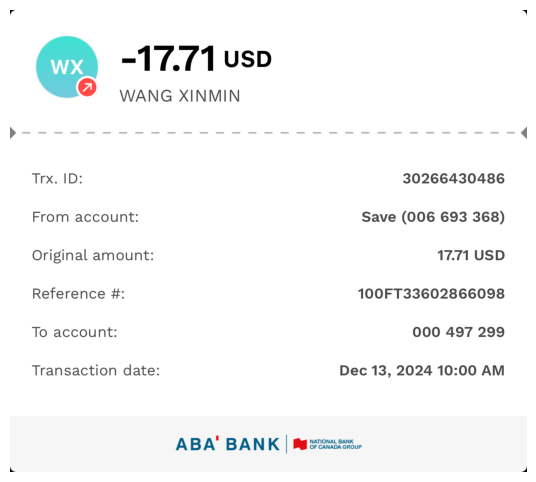

In [2]:
image_path = "../data/raw/IMG_7538.PNG"
image = Image.open(image_path)

# Display Image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")
plt.show()

## Preprocess Image

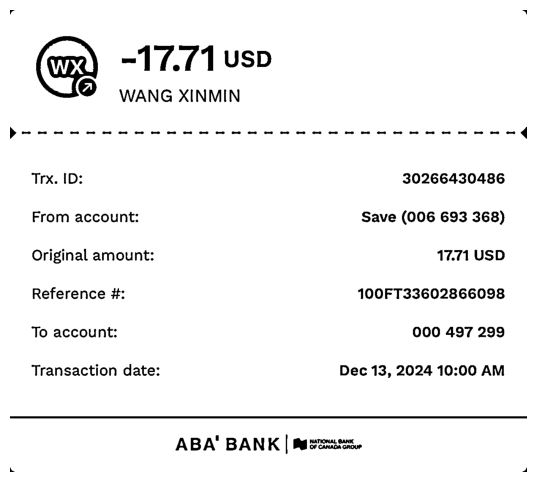

In [10]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply slight Gaussian Blur to remove noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Use Adaptive Thresholding for better text contrast
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
    
    return thresh

preprocess = preprocess_image(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(preprocess, cmap="gray")
plt.axis("off")
plt.show()

## Apply OCR to Extract Text

In [11]:
def extract_text_from_image(image) -> str:
    """Extracts text from an image using Tesseract OCR."""

    # Apply OCR with PSM mode (6 for multi-column detection)
    custom_config = r'--oem 3 --psm 6'  # Try changing to --psm 4 if results are still wrong
    extracted_text = pytesseract.image_to_string(image, config=custom_config)
    
    return extracted_text.strip()

# Extract Text
extracted_text = extract_text_from_image(image_path)
print("Extracted Text:\n", extracted_text)

Extracted Text:
 4 »

& -17.71 usp
7) WANG XINMIN

4 <
Trx. ID: 30266430486
From account: Save (006 693 368)
Original amount: 17.71 USD
Reference #: 100FT33602866098
To account: 000 497 299
Transaction date: Dec 13, 2024 10:00 AM

ABA' BANK | Besa.
U y


## Classify Bank

In [18]:
def classify_bank(extracted_text: str) -> str:
    """Classifies the bank based on keywords in the extracted text."""
    bank_keywords = {
        "ABA Bank": ["ABA' BANK", "NATIONAL BANK OF CANADA GROUP"]
    }
    
    # Check for keywords in extracted text
    for bank, keywords in bank_keywords.items():
        for keyword in keywords:
            if keyword.lower() in extracted_text.lower():
                return bank
    return "Unknown Bank"

# Identify Bank
bank_name = classify_bank(extracted_text)
print(f"Identified Bank: {bank_name}")

Identified Bank: ABA Bank


## Extract Key Transaction Details

In [20]:
def extract_transaction_data(extracted_text: str) -> dict:
    """Extracts transaction details using regex."""
    
    patterns = {
        "transaction_id": r"Trx. ID: (\d+)",
        "amount": r"Original amount: (\d+\.\d+)",
        "date": r"Transaction date: (.+)"
    }
    
    extracted_data = {}
    
    for key, pattern in patterns.items():
        match = re.search(pattern, extracted_text)
        
        if match:
            extracted_data[key] = match.group(1)
        else:
            extracted_data[key] = "None"
        
    return extracted_data

# Extract Transaction Data
transaction_data = extract_transaction_data(extracted_text)
transaction_data["bank"] = bank_name
print("Extracted Transaction Data:\n", json.dumps(transaction_data, indent=2))

Extracted Transaction Data:
 {
  "transaction_id": "30266430486",
  "amount": "17.71",
  "date": "Dec 13, 2024 10:00 AM",
  "bank": "ABA Bank"
}


## Save Results as JSON

In [14]:
output_path = "../data/processed/transaction_data.json"

with open(output_path, "w") as file:
    json.dump(transaction_data, file, indent=2)
    
print(f"Data saved at: {output_path}")

Data saved at: ../data/processed/transaction_data.json
